# ktrainから使うBERT

ktrainはKerasのラッパーであり、ニューラルネットワークを簡単に学習できます。わずか数行のコードを書くだけでモデルを構築し、最適な学習率を推定し、テキストの読み込みや前処理を行い、モデルを学習できます。

- https://github.com/amaiya/ktrain

## 準備

### パッケージのインストール

In [1]:
!pip install -q ktrain==0.27.3

     |████████████████████████████████| 25.3 MB 49.8 MB/s 
     |████████████████████████████████| 6.8 MB 20.6 MB/s 
     |████████████████████████████████| 981 kB 37.2 MB/s 
     |████████████████████████████████| 263 kB 45.7 MB/s 
     |████████████████████████████████| 1.9 MB 34.0 MB/s 
     |████████████████████████████████| 1.2 MB 39.2 MB/s 
     |████████████████████████████████| 468 kB 47.3 MB/s 
     |████████████████████████████████| 895 kB 45.6 MB/s 
     |████████████████████████████████| 3.3 MB 36.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


### インポート

In [2]:
import os.path

import ktrain
import tensorflow as tf
from ktrain import text

### データセットのダウンロード

データセットは以前にも使ったIMDB映画レビューデータセットを使います。

In [3]:
dataset = tf.keras.utils.get_file(
    fname="aclImdb.tar.gz",
    origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    extract=True,
)

84140032/84125825 [==============================] - 2s 0us/step


読み込むときのために、フォルダの構造を確認しておきましょう。
`train`と`test`の下に`pos`と`neg`フォルダがあり、その中にプレーンテキストでレビューが格納されています。おおよそ、以下の構造になります。

```bash
├── datadir
│   ├── train
│   │   ├── pos       # 肯定的なレビューのテキストを含むフォルダ
│   │   └── neg       # 否定的なレビューのテキストを含むフォルダ
│   └── test 
│        ├── pos       # 肯定的なレビューのテキストを含むフォルダ
│        └── neg       # 否定的なレビューのテキストを含むフォルダ
```

In [4]:
IMDB_DATADIR = os.path.join(os.path.dirname(dataset), "aclImdb")
print(IMDB_DATADIR)

/root/.keras/datasets/aclImdb


## 前処理

`texts_from_folder`関数を使うと、学習用と検証用のデータを指定したフォルダから読み込み、BERTに必要な形式へ自動的に変換してくれます。この関数は、以下のようなフォルダ構造でコーパスが格納されていることを仮定しています。

```bash
├── datadir
│   ├── train
│   │   ├── class0       # folder containing documents of class 0
│   │   ├── class1       # folder containing documents of class 1
│   │   ├── class2       # folder containing documents of class 2
│   │   └── classN       # folder containing documents of class N
│   └── test 
│       ├── class0       # folder containing documents of class 0
│       ├── class1       # folder containing documents of class 1
│       ├── class2       # folder containing documents of class 2
│       └── classN       # folder containing documents of class N
```

各サブフォルダは、プレーンテキスト形式で文書を格納していなければなりません。今回の場合、サブフォルダ名は`pos`と`neg`なので、それを`classes`引数に指定します。

In [5]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_folder(
    IMDB_DATADIR,
    maxlen=128,
    preprocess_mode="bert",
    train_test_names=["train", "test"],
    classes=["pos", "neg"],
)

detected encoding: utf-8
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


## 事前学習済みBERTの読み込み

まずは、`text_classifier`関数を使って、テキスト分類モデルを構築します。今回はBERTを使いたいため、関数の第一引数に`bert`と渡しています。それ以外に以下の文字列を渡せます。

- fasttext: FastTextモデル
- nbsvm: NBSVM（ナイーブベイズとSVMの組み合わせ）
- logreg: 埋め込み層を使ったロジスティック回帰
- bigru: 事前学習済み単語埋め込みを使った双方向GRU
- distilbert: DistilBertモデル

その後、`get_learner`関数を呼び出して、モデルを学習するための`Learner`インスタンスを作成します。

In [6]:
model = text.text_classifier(
    name="bert",
    train_data=(x_train, y_train),
    preproc=preproc
)
learner = ktrain.get_learner(
    model,
    train_data=(x_train, y_train),
    val_data=(x_test, y_test),
    batch_size=6
)

Is Multi-Label? False
maxlen is 128
done.


## モデルの学習

次に、`lr_find`と`lr_plot`メソッドを用いて、良さそうな学習率を探索します。

In [7]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/1024
4167/4167 [==============================] - 539s 123ms/step - loss: 3.0832 - accuracy: 0.5975


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


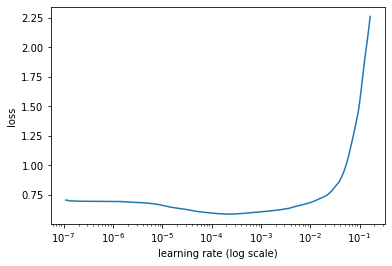

In [8]:
learner.lr_plot()

ここまで来たら、あとは`fit_onecycle`メソッドを呼び出して、モデルを学習します。
第1引数に学習率、第２引数にエポック数を指定しています。

In [9]:
learner.fit_onecycle(2e-5, 1)



begin training using onecycle policy with max lr of 2e-05...
4167/4167 [==============================] - 1952s 463ms/step - loss: 0.3440 - accuracy: 0.8438 - val_loss: 0.2608 - val_accuracy: 0.8902


## モデルを用いた予測

学習したモデルを用いて、新しい映画レビューに対して予測をしてみましょう。その際、`texts_from_folder`によって返された`preproc`オブジェクトが重要になります。このオブジェクトを用いて、データをモデルが期待する形式に前処理します。

In [11]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [12]:
data = [
    "This movie was horrible! The plot was boring. Acting was okay, though.",
    "The film really sucked. I want my money back.",
    "What a beautiful romantic comedy. 10/10 would see again!"
]

In [13]:
predictor.predict(data)

['neg', 'neg', 'pos']

ご覧のように、モデルは正しいと思われる予測を返しています。上ではクラスそのものを返していますが、`predictor`インスタンスは、各クラスに対する予測値の確率を返すこともできます。まず、クラスとその順番を表示してみましょう。クラスposはポジティブなセンチメント、negはネガティブなセンチメントを表しています。そして、その確率を見るために、`predictor.predict`を`return_proba=True`で再実行します。


In [14]:
predictor.get_classes()

['neg', 'pos']

In [15]:
predictor.predict(data, return_proba=True)

array([[0.9987012 , 0.00129881],
       [0.9957632 , 0.00423682],
       [0.00199427, 0.9980057 ]], dtype=float32)

## モデルの保存と読み込み

では最後に、モデルを保存し読み込んでみましょう。`save`メソッドで保存したモデルは、`load_predictor`を呼び出すことで読み込むことができます。

In [17]:
filepath = "/tmp/imdb_predictor"
predictor.save(filepath)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [18]:
predictor = ktrain.load_predictor(filepath)

In [19]:
predictor.predict(["Groundhog Day is my favorite movie of all time!"])

['pos']

## 参考資料

- [ktrain/examples/text/IMDb-BERT.ipynb](https://github.com/amaiya/ktrain/blob/master/examples/text/IMDb-BERT.ipynb)
- [Text Classification Example: Sentiment Analysis with IMDb Movie Reviews](https://nbviewer.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-04-text-classification.ipynb)